Files already downloaded and verified
Files already downloaded and verified


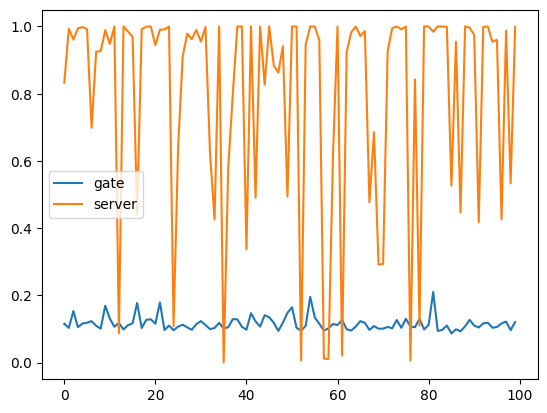

In [2]:
from Models import mobilenetv2
import sys

middle_size = 4
width = 16
height = 16

client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10',
                                                  device='cuda:0',partition=-1)

from Dataloaders import dataloader_cifar10

train, test, val = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)
import torch
import torch.optim as optim
import torch.nn as nn

device = torch.device('cuda:0')
client = client.to(device)
server = server.to(device)
client = client.eval()
server = server.eval()

middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)
middle.load_state_dict(torch.load('model_middle_'+str(middle_size)+'.pth'))
middle = middle.to(device)
middle = middle.eval()

from Models import gatedmodel
gate = gatedmodel.GatedRegression(input_size=middle_size, width=width, height=height, output_size=10)

gate = gate.to(device)
gate.load_state_dict(torch.load('mobile_cifar-10_gate_'+str(middle_size)+'.pth'))

from tqdm import tqdm
from Utils import utils

import sys
import torchsummary
epochs = 100
min_val_loss = 1000000
with torch.no_grad():
    for i, data in enumerate(test):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        client_out = client(inputs)
        middle_in = middle.in_layer(client_out).detach()

        gate_out = gate(middle_in)
        gate_out = gate_out.detach()
        gate_out = torch.softmax(gate_out, dim=1)
        # gate_out = torch.argmax(gate_out, dim=1)
        gate_out = torch.gather(gate_out, 1, labels.view(-1, 1))

        server_out = server(client_out)
        server_out = torch.softmax(server_out, dim=1)
        # server_out = torch.argmax(server_out, dim=1)
        server_out = torch.gather(server_out, 1, labels.view(-1, 1))

        break
        
# plot 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
x = np.arange(100)
# plot the data
plt.plot(x, gate_out.cpu().numpy(), label='gate')
plt.plot(x, server_out.cpu().numpy(), label='server')
plt.legend()
plt.show()

In [24]:
from Models import mobilenetv2
import sys

middle_size = 4
width = 16
height = 16
normal_para = 6

client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10',
                                                  device='cuda:0',partition=-1)

from Dataloaders import dataloader_cifar10

train, test, val = dataloader_cifar10.Dataloader_cifar10_val(train_batch=32, test_batch=100, seed=2024)
import torch
import torch.optim as optim
import torch.nn as nn

device = torch.device('cuda:0')
client = client.to(device)
server = server.to(device)
client = client.eval()
server = server.eval()

middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)
middle.load_state_dict(torch.load('mobile_cifar-10_middle_'+str(middle_size)+'.pth'))
middle = middle.to(device)
middle = middle.eval()

from Models import gatedmodel
gate = gatedmodel.ExitGate(in_planes=middle_size, height=height, width=width) # sigmoid
gate.load_state_dict(torch.load('mobile_cifar-10_gate_'+str(middle_size)+'.pth'))
gate = gate.to(device)
gate = gate.eval()

criterion = nn.MSELoss()
optimizer = optim.Adam(gate.parameters(), lr=0.001) # 0.01 is too big

from tqdm import tqdm
from Utils import utils

import sys
import numpy as np
epochs = 100
max_val_acc = 0
with torch.no_grad():
    val_acc = 0
    gate_exit = 0
    send_count = 0
    for i, data in enumerate(test):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        client_out = client(inputs)
        middle_out = middle.in_layer(client_out).detach()

        gate_out = gate(middle_out).squeeze()
        middle_out2 = middle.out_layer(middle_out).detach()
        server_out = server(middle_out2)
        # get the number of 0 and 1
        server_out = torch.softmax(server_out, dim=1)
        server_out = torch.argmax(server_out, dim=1)
        server_out = torch.eq(server_out, labels).float()

        # print('gate_out: ', torch.where(gate_out>0.5, torch.tensor(1).to(device), torch.tensor(0).to(device)))

        # gate_out = torch.round(gate_out)
        gate_out = torch.gt(gate_out, 0.9).float()
        gate_exit += torch.sum(gate_out).item()

        # get ther server_out [ gate_out == 1]
        s = torch.where(gate_out == 1)[0]
        server_out = server_out[s]
        gate_out = gate_out[s]
        gate_acc = torch.eq(server_out, gate_out).float()
        val_acc += torch.sum(gate_acc).item()
        send_count += len(s)

        # print the rate of gate exit
    gate_exit = gate_exit / len(val.dataset)
    val_acc = val_acc / max(1,send_count)
    print('gate_exit: ', gate_exit)
    print('val_acc: ', val_acc)

Files already downloaded and verified
Files already downloaded and verified
gate_exit:  0.1696
val_acc:  0.8702830188679245


In [25]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
print(len(provinces))
print(len(alphabets))
print(len(ads))

34
25
35
